In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
import holidays

In [21]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2018-01-01', '2019-01-01', '2020-01-01'])})  
lny = pd.DataFrame({'holiday': 'Lunar New Year', 'ds' : pd.to_datetime(['2018-02-16', '2018-02-17', '2019-02-05', '2019-02-06', '2020-01-25', '2020-01-26'])}) 
gf = pd.DataFrame({'holiday': "Good Friday", 'ds' : pd.to_datetime(['2018-03-30', '2019-04-19', '2020-04-10'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2018-05-01', '2019-05-01', '2020-05-01'])})
eaf = pd.DataFrame({'holiday': 'Eid al-Fitr', 'ds' : pd.to_datetime(['2018-06-14', '2018-06-15', '2019-06-04', '2019-06-05','2020-05-23', '2020-05-24'])})
nd = pd.DataFrame({'holiday': 'National Day', 'ds' : pd.to_datetime(['2018-08-09', '2019-08-09', '2020-08-09'])})
eaa = pd.DataFrame({'holiday': 'Eid al-Adha', 'ds' : pd.to_datetime(['2018-08-21', '2018-08-22', '2019-08-11', '2019-08-12', '2020-07-31'])})
dwl = pd.DataFrame({'holiday': "Diwali", 'ds' : pd.to_datetime(['2018-11-06', '2019-10-28', '2020-11-14'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2018-12-25', '2019-12-25', '2020-12-25'])})

sg_public_holidays = pd.concat([ny, lny, gf, lab, eaf, nd, eaa, dwl, christ])

In [22]:
sales_1 = pd.read_excel('Master Data (Sales).xlsx', sheet_name=0, parse_dates = ['Date of Sale'])

In [23]:
sales_1.drop(['Product - Chinese Name', 'Product - English Name'], axis=1, inplace=True)

In [24]:
sales_1_A013 = sales_1[sales_1['SKU']=='A013']

In [25]:
sales_1_A013.set_index('Date of Sale', inplace=True)

In [26]:
sales_1_A013

,SKU,Amount Sold
Date of Sale,,
2018-01-01,A013,14
2018-01-02,A013,7
2018-01-03,A013,7
2018-01-04,A013,6
2018-01-05,A013,15
...,...,...
2020-12-27,A013,3
2020-12-28,A013,5
2020-12-29,A013,5


In [27]:
idx = pd.date_range('2018-01-01', '2020-12-31')

sales_1_A013 = sales_1_A013.reindex(idx, fill_value=0)
sales_1_A013

,SKU,Amount Sold
2018-01-01,A013,14
2018-01-02,A013,7
2018-01-03,A013,7
2018-01-04,A013,6
2018-01-05,A013,15
...,...,...
2020-12-27,A013,3
2020-12-28,A013,5
2020-12-29,A013,5
2020-12-30,A013,8


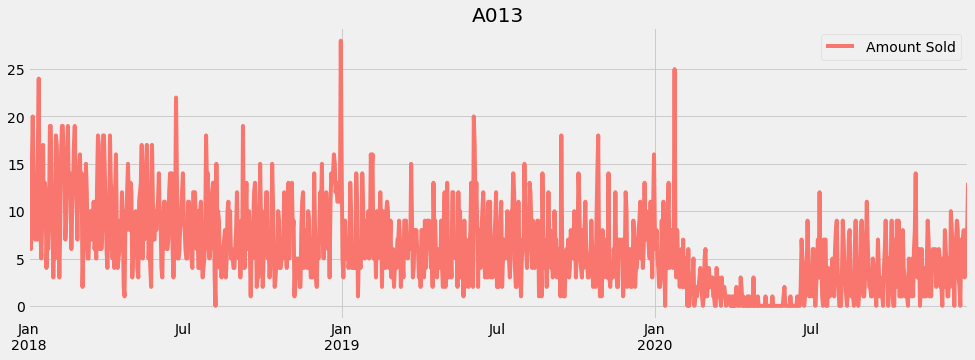

In [103]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
sales_1_A013.plot(kind='line', figsize=(15,5), color=color_pal[0], title='A013')
plt.show()

In [28]:
sales_1_A013.drop('SKU', axis=1, inplace=True)

In [29]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(sales_1_A013, label='Amount Sold')

features_and_target = pd.concat([X, y], axis=1)

In [30]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Amount Sold
2018-01-01,0,0,1,1,2018,1,1,1,14
2018-01-02,0,1,1,1,2018,2,2,1,7
2018-01-03,0,2,1,1,2018,3,3,1,7
2018-01-04,0,3,1,1,2018,4,4,1,6
2018-01-05,0,4,1,1,2018,5,5,1,15


In [31]:
split_date = '2020-11-30'
A013_train = sales_1_A013.loc[sales_1_A013.index <= split_date].copy()
A013_test = sales_1_A013.loc[sales_1_A013.index > split_date].copy()

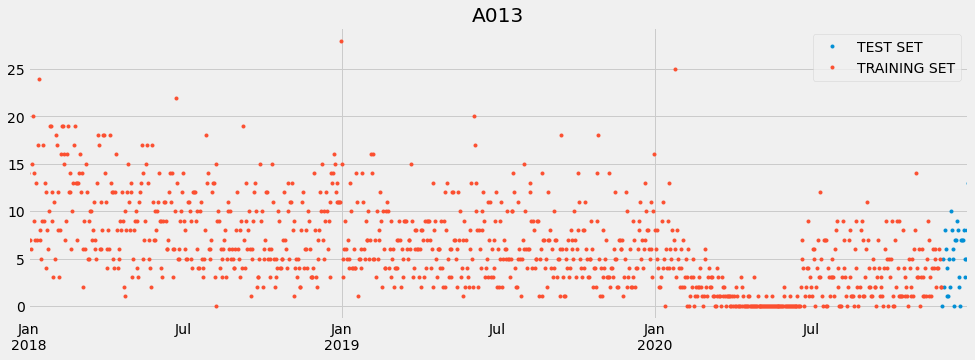

In [32]:
A013_test \
    .rename(columns={'Amount Sold': 'TEST SET'}) \
    .join(A013_train.rename(columns={'Amount Sold': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='A013', style='.')
plt.show()

In [33]:
# Format data for prophet model using ds and y
A013_train.reset_index() \
    .rename(columns={'index':'ds',
                     'Amound Sold':'y'}).head()

,ds,Amount Sold
0,2018-01-01,14
1,2018-01-02,7
2,2018-01-03,7
3,2018-01-04,6
4,2018-01-05,15


In [35]:
#model = Prophet()
model = Prophet(yearly_seasonality=True, holidays=sg_public_holidays)
model.fit(A013_train.reset_index() \
              .rename(columns={'index':'ds',
                               'Amount Sold':'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
A013_test_fcst = model.predict(df=A013_test.reset_index() \
                                   .rename(columns={'index':'ds'}))

In [37]:
A013_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Diwali,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-01,3.176851,-2.796278,5.091991,3.176851,3.176851,0.0,0.0,0.0,0.0,...,-1.639701,-1.639701,-1.639701,-0.095474,-0.095474,-0.095474,0.0,0.0,0.0,1.441677
1,2020-12-02,3.178532,-1.758347,5.938458,3.178532,3.178532,0.0,0.0,0.0,0.0,...,-1.394826,-1.394826,-1.394826,0.060084,0.060084,0.060084,0.0,0.0,0.0,1.843790
2,2020-12-03,3.180214,-0.916586,6.909204,3.180214,3.180214,0.0,0.0,0.0,0.0,...,-0.472383,-0.472383,-0.472383,0.236704,0.236704,0.236704,0.0,0.0,0.0,2.944534
3,2020-12-04,3.181895,2.369153,10.265027,3.181895,3.181895,0.0,0.0,0.0,0.0,...,2.769439,2.769439,2.769439,0.432501,0.432501,0.432501,0.0,0.0,0.0,6.383834
4,2020-12-05,3.183576,2.261826,9.966171,3.183576,3.183576,0.0,0.0,0.0,0.0,...,2.434198,2.434198,2.434198,0.645130,0.645130,0.645130,0.0,0.0,0.0,6.262903


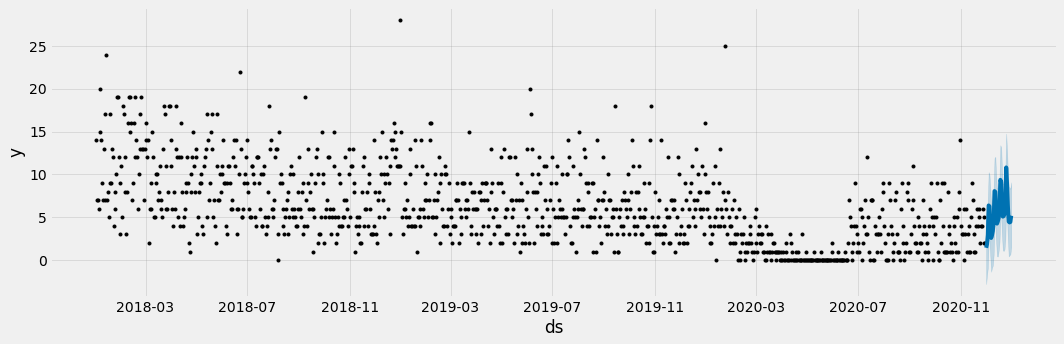

In [38]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(A013_test_fcst,
                 ax=ax)
plt.show()

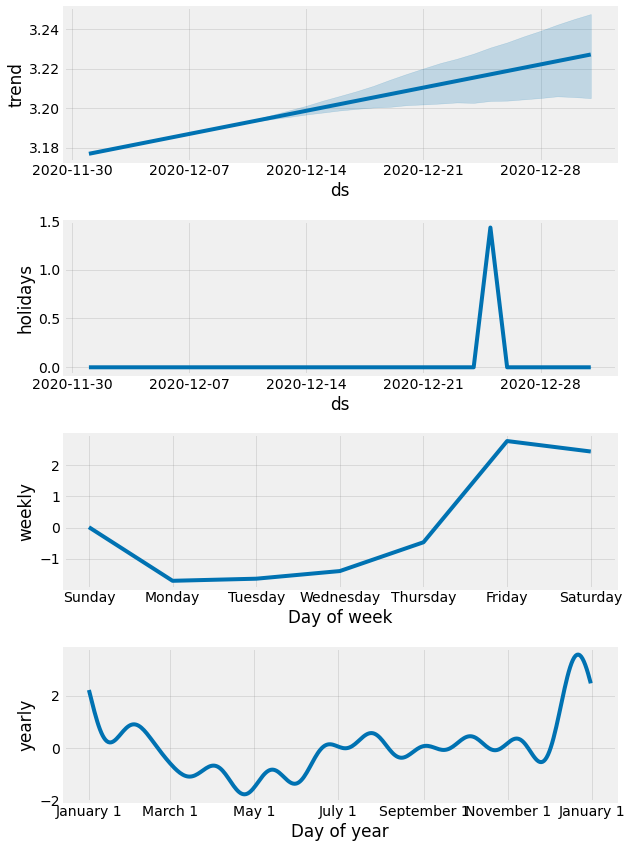

In [39]:
fig = model.plot_components(A013_test_fcst)

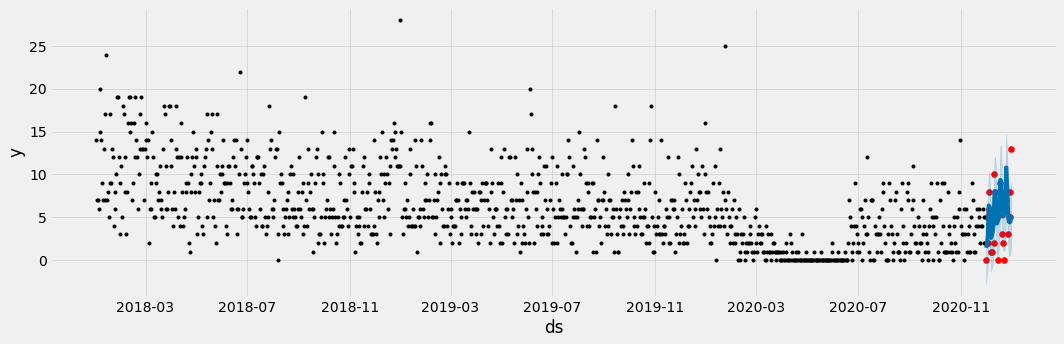

In [40]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(A013_test.index, A013_test['Amount Sold'], color='r')
fig = model.plot(A013_test_fcst, ax=ax)

In [41]:
mean_squared_error(y_true=A013_test['Amount Sold'],
                   y_pred=A013_test_fcst['yhat'])

7.001297515958151

In [42]:
mean_absolute_error(y_true=A013_test['Amount Sold'],
                   y_pred=A013_test_fcst['yhat'])

2.005339796768926

In [ ]:
#error decreased after we trained up to Nov 2020 instead of by yearly basis, that is up to 1 Jan 2020 only
#explored with public holidays but it does not seem to help, so we decided to not use it